# Objective
---
Program count reads an image file named count.jpg containing palm trees in a
plantation. It outputs a new JPEG image with numbered bounding boxes overlaid on
the original image. Each box marks a detected palm tree, numbered sequentially
from 1 onwards. Using computer vision techniques, the program automatically
identifies and counts the palm trees. The resulting output image helps plantation
managers efficiently track and monitor their palm tree inventory.​ry.​

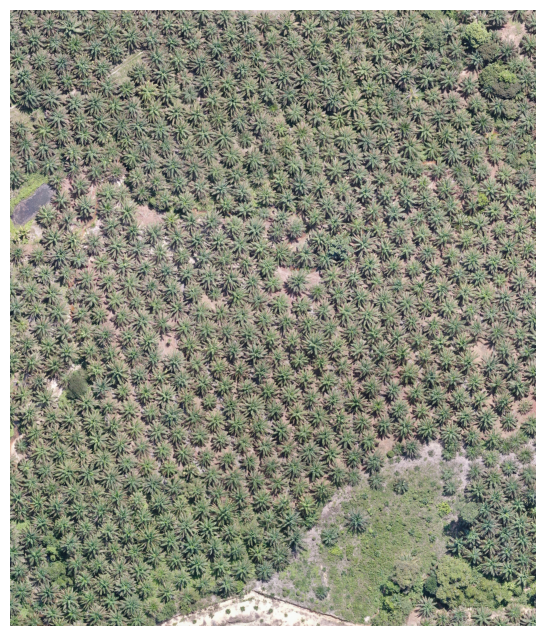

In [29]:
# File path
input = "../data/count/raw/count1.jpeg"
# Read the image
img = mpimg.imread(input)
# Display the image
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()


# Data Loading
---

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import seaborn as sns

import shutil
import os
import random
import cv2
import kagglehub
from PIL import Image

import torch
from ultralytics import YOLO
import supervision as sv
from roboflow import Roboflow

import warnings
warnings.filterwarnings('ignore')

In [123]:
dataset_path = "../data/count/raw/dataset"
api=""

if not os.path.exists(dataset_path):
    rf = Roboflow(api_key=api, model_format="yolo11")
    dataset = rf.workspace().project("palm-tree-qb2kl-re9jg").version("1").download(location=dataset_path)
    
    print("Downloaded and extracted.")
else:
    print("Dataset already exists. Skipping download.")


Dataset already exists. Skipping download.


In [37]:
splits = ['train', 'valid', 'test']
image_exts = ('.jpg', '.jpeg', '.png')

for split in splits:
    image_dir = os.path.join(dataset_path, split,'images')
    images = [f for f in os.listdir(image_dir) if f.endswith(image_exts)]
    print(f"{split}: {len(images)} images")

train: 3156 images
valid: 896 images
test: 443 images


In [47]:
new_dataset_path = "../data/count/raw/new_dataset"

# Collect all image paths with labels
all_data = []

for split in splits:
    image_dir = os.path.join(dataset_path, split, "images")
    label_dir = os.path.join(dataset_path, split, "labels")

    for filename in os.listdir(image_dir):
        if filename.lower().endswith(image_exts):
            image_path = os.path.join(image_dir, filename)
            label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")
            all_data.append((split, image_path, label_path))

# Shuffle and limit image to 1000
random.shuffle(all_data)
limited_data = all_data[:1000]

# Copy to new path
for split in splits:
    os.makedirs(os.path.join(new_dataset_path, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(new_dataset_path, split, "labels"), exist_ok=True)

# Distribute back proportionally to original splits
split_counts = {s: 0 for s in splits}
for s, _, _ in limited_data:
    split_counts[s] += 1

print("Distributing:", split_counts)

# Copy files
for s, img_path, lbl_path in limited_data:
    dst_img_path = os.path.join(new_dataset_path, s, "images", os.path.basename(img_path))
    dst_lbl_path = os.path.join(new_dataset_path, s, "labels", os.path.basename(lbl_path))
    shutil.copy(img_path, dst_img_path)
    if os.path.exists(lbl_path):
        shutil.copy(lbl_path, dst_lbl_path)

# Copy data.yaml
shutil.copy('../data/count/raw/dataset/data.yaml', '../data/count/raw/new_dataset/data.yaml')

Distributing: {'train': 692, 'valid': 213, 'test': 95}


'../data/count/raw/new_dataset/data.yaml'


# Exploratory Data Analysis
---
So, before doing anything to the data, it's best practice to understand what’s going on with it. In this dataset, there are two folders: an image folder and a CSV folder. The image folder contains, well, obviously the images, and the CSV folder contains the labels or the coordinates for the bounding boxes. I’ll check everything and try to display what the data looks like.

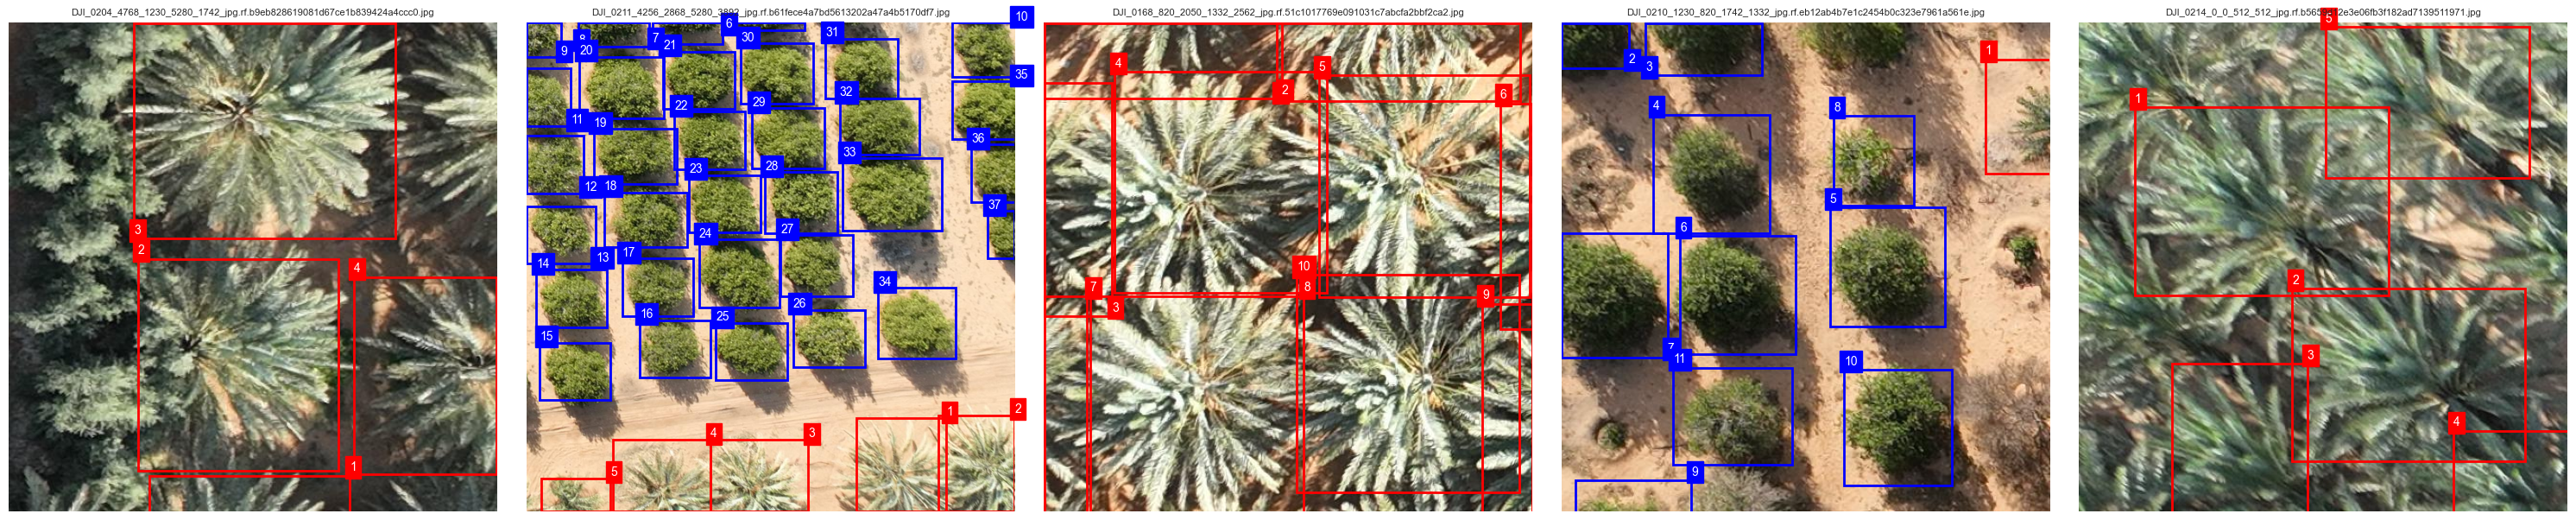

In [64]:
# Directory
image_dir = '../data/count/raw/new_dataset/train/images'
label_dir = '../data/count/raw/new_dataset/train/labels'
image_exts = ('.jpg', '.jpeg', '.png')

# Assign colors
class_colors = {0:'red', 1:'blue'}

# Get image files
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(image_exts)]
random_images = random.sample(image_files, 5)

plt.figure(figsize=(30, 9))
for i, filename in enumerate(random_images, 1):
    img_path = os.path.join(image_dir, filename)
    img = mpimg.imread(img_path)
    height, width = img.shape[:2]

    ax = plt.subplot(1, 5, i)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(filename, fontsize=8)

    label_file = os.path.splitext(filename)[0] + '.txt'
    label_path = os.path.join(label_dir, label_file)

    if not os.path.exists(label_path):
        print(f"[!] No label file for: {filename}")
        continue

    with open(label_path, 'r') as f:
        lines = f.readlines()
        if not lines:
            print(f"[!] Empty label file: {filename}")

        for idx, line in enumerate(lines, 1):
            parts = line.strip().split()
            if len(parts) != 9:
                print(f"[!] Bad label line: {line}")
                continue

            class_id = int(parts[0])
            coords = list(map(float, parts[1:]))

            polygon_coords = [(coords[j] * width if j % 2 == 0 else coords[j] * height) for j in range(8)]
            polygon_points = [(polygon_coords[j], polygon_coords[j + 1]) for j in range(0, 8, 2)]

            color = class_colors.get(class_id, 'yellow')  # fallback to yellow if class is unknown

            polygon = Polygon(polygon_points, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(polygon)

            ax.text(polygon_points[0][0], polygon_points[0][1] - 5, str(idx),
                    color='white', fontsize=10, backgroundcolor=color)

plt.tight_layout()
plt.show()

This dataset contains 2 classes, palm tree and a regular tree. Even if the objective of this project is only detecting a palm tree, I will not remove the regular tree class.

**Why?** 

This is a common machine learning technique that is known as

_**Hard Negative Mining,**_ Teaching the model what not to detect as the target class by showing it similar-looking but different examples.

Or this, someone I found on Reddit explained it in a really good way.


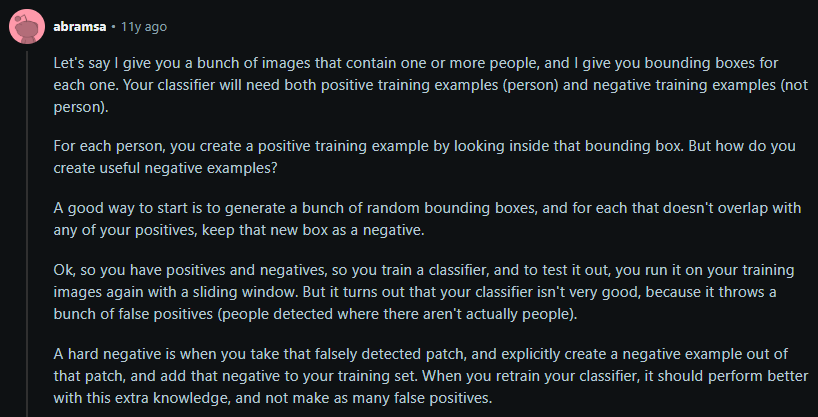

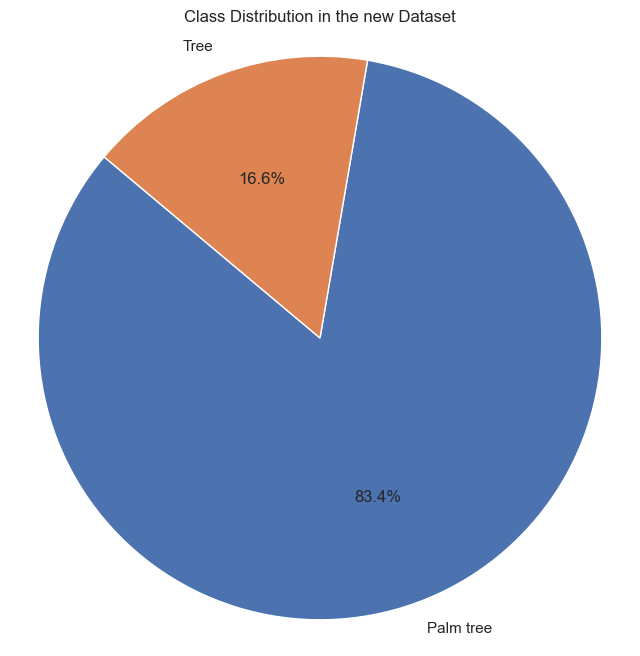

In [48]:
sns.set(style="whitegrid")

yaml_path = os.path.join(new_dataset_path, "data.yaml")
class_counts = Counter()

# Count class IDs from all label files
for split in splits:
    label_dir = os.path.join(new_dataset_path, split, "labels")
    for filename in os.listdir(label_dir):
        if filename.endswith(".txt"):
            with open(os.path.join(label_dir, filename), "r") as f:
                lines = f.readlines()
                for line in lines:
                    if line.strip():
                        class_id = int(line.strip().split()[0])
                        class_counts[class_id] += 1

# Load class names from data.yaml
with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)
    class_names = data["names"]

# Prepare data
labels = [class_names[class_id] for class_id in sorted(class_counts)]
sizes = [class_counts[class_id] for class_id in sorted(class_counts)]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title("Class Distribution in the new Dataset")
plt.show()


**Imbalance Data?**

The class imbalance shown in the dataset, 83.4% palm trees and 16.6% trees is actually very acceptable because the "Tree" class is not meant to be predicted as a separate category, but as hard negatives to improve model performance. 

It can reduce false positives by exposing it to challenging, visually similar instances. Since the primary goal is binary classification, this level of imbalance is appropriate and beneficial, as it strengthens the model’s ability to generalize without overwhelming it with irrelevant negative samples.

In [77]:
model = YOLO('yolo11n.pt')

**Why YOLO?** 

It’s a state-of-the-art object detection model, fast, accurate, and reliable.
Why reinvent the wheel when YOLO already does exactly what I need? and considerng the time, it's way more efficient to use a proven solution than build something from scratch.

In [80]:
num_workers = os.cpu_count()
results = model.train(data="../data/count/raw/new_dataset/data.yaml", epochs=40, imgsz=640, cache=True, patience=20,workers=num_workers, device='cpu')

Ultralytics 8.3.162  Python-3.11.0 torch-2.1.0+cpu CPU (Intel Core(TM) i7-8750H 2.20GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/count/raw/new_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12

train: Scanning C:\Users\zidny\Documents\CV\AIEngineerV2025-20250114\data\count\raw\new_dataset\train\labels.cache... 


WARNING cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.7GB RAM): 100%|██████████| 692/692 [00:06<00:00, 99.17it/s] 


val: Fast image access  (ping: 0.30.1 ms, read: 150.0165.5 MB/s, size: 443.3 KB)


val: Scanning C:\Users\zidny\Documents\CV\AIEngineerV2025-20250114\data\count\raw\new_dataset\valid\labels.cache... 21


WARNING cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.2GB RAM): 100%|██████████| 213/213 [00:02<00:00, 101.60it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40         0G       2.12      3.043      1.489        484        640: 100%|██████████| 44/44 [11:29<00:00, 15
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:38<


                   all        213      12657      0.153      0.788      0.617      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40         0G      1.737      1.374      1.194        169        640: 100%|██████████| 44/44 [10:08<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/7 [00:00<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:17<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  86%|████████▌ | 6/7 [01:29<

WARNING NMS time limit 3.050s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:39<

                   all        213      12657      0.723      0.635      0.635      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40         0G      1.671      1.014       1.17        369        640: 100%|██████████| 44/44 [10:12<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/7 [00:00<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:16<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  43%|████▎     | 3/7 [00:48<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  71%|███████▏  | 5/7 [01:17<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  86%|████████▌ | 6/7 [01:34<

WARNING NMS time limit 3.050s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:44<

                   all        213      12657       0.76      0.569      0.583      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40         0G      1.584     0.9319      1.156        562        640: 100%|██████████| 44/44 [09:52<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/7 [00:00<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:17<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  29%|██▊       | 2/7 [00:37<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  43%|████▎     | 3/7 [00:48<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  57%|█████▋    | 4/7 [01:07<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  71%|███████▏  | 5/7 [01:19<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  86%|████████▌ | 6/7 [01:36<

WARNING NMS time limit 3.050s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:46<

                   all        213      12657      0.897      0.576      0.645      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40         0G      1.538     0.8657      1.133        538        640: 100%|██████████| 44/44 [10:03<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:15<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:34<

                   all        213      12657      0.917      0.838       0.88      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40         0G      1.525     0.8395      1.132        394        640: 100%|██████████| 44/44 [10:08<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:15<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:35<

                   all        213      12657      0.936      0.894      0.928      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40         0G      1.496      0.787       1.13        261        640: 100%|██████████| 44/44 [09:57<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:15<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:35<

                   all        213      12657      0.905      0.885      0.903      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40         0G      1.465     0.7829       1.11        718        640: 100%|██████████| 44/44 [09:48<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:15<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:36<

                   all        213      12657      0.915      0.902      0.929      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40         0G      1.466     0.7585      1.106        359        640: 100%|██████████| 44/44 [10:07<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:32<

                   all        213      12657      0.926      0.907      0.937      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40         0G      1.457     0.7567      1.119        158        640: 100%|██████████| 44/44 [09:56<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:16<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  29%|██▊       | 2/7 [00:36<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  43%|████▎     | 3/7 [00:48<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  71%|███████▏  | 5/7 [01:17<

WARNING NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:44<

                   all        213      12657      0.941      0.765      0.802      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40         0G      1.439     0.7156      1.089        477        640: 100%|██████████| 44/44 [10:15<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:36<

                   all        213      12657      0.941      0.911      0.941      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40         0G      1.421     0.7146      1.102        161        640: 100%|██████████| 44/44 [09:44<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:31<

                   all        213      12657      0.938       0.91      0.939       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40         0G      1.415     0.6915      1.089        485        640: 100%|██████████| 44/44 [09:57<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:27<

                   all        213      12657      0.936      0.905       0.94      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40         0G      1.418     0.6843      1.096        237        640: 100%|██████████| 44/44 [09:56<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:38<

                   all        213      12657      0.942      0.915      0.944      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40         0G       1.41      0.683      1.099        166        640: 100%|██████████| 44/44 [09:56<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:31<

                   all        213      12657      0.938      0.916      0.946      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40         0G      1.403     0.6712      1.089        324        640: 100%|██████████| 44/44 [10:02<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:29<

                   all        213      12657      0.935      0.918      0.942      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40         0G      1.386     0.6594      1.091        252        640: 100%|██████████| 44/44 [09:56<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:25<

                   all        213      12657      0.939      0.912      0.947      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40         0G      1.376     0.6518      1.078        447        640: 100%|██████████| 44/44 [09:53<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:26<

                   all        213      12657      0.949      0.909      0.946      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40         0G      1.382      0.658      1.084        293        640: 100%|██████████| 44/44 [09:58<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:26<

                   all        213      12657      0.947      0.917      0.947      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40         0G      1.365     0.6448      1.078        157        640: 100%|██████████| 44/44 [10:06<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:25<

                   all        213      12657       0.95      0.915      0.949      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40         0G      1.356     0.6313       1.07        518        640: 100%|██████████| 44/44 [10:00<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:25<

                   all        213      12657      0.948       0.92      0.949      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40         0G       1.38     0.6398      1.079        285        640: 100%|██████████| 44/44 [10:09<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:25<

                   all        213      12657       0.95      0.916      0.951      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40         0G      1.341     0.6251      1.082        224        640: 100%|██████████| 44/44 [09:57<00:00, 13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:25<

                   all        213      12657      0.947      0.921       0.95      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40         0G      1.331     0.6217      1.067        519        640: 100%|██████████| 44/44 [07:47<00:00, 10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:55<

                   all        213      12657      0.948       0.92      0.951      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40         0G      1.337     0.6236      1.069        112        640: 100%|██████████| 44/44 [06:11<00:00,  8
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:55<

                   all        213      12657      0.945       0.92       0.95      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40         0G      1.335     0.6102       1.07        399        640: 100%|██████████| 44/44 [06:08<00:00,  8
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<

                   all        213      12657      0.951      0.922      0.952      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40         0G      1.342     0.6141      1.066        397        640: 100%|██████████| 44/44 [06:15<00:00,  8
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<

                   all        213      12657      0.953      0.923      0.955      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40         0G      1.336     0.6116      1.078        329        640: 100%|██████████| 44/44 [06:07<00:00,  8
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<

                   all        213      12657      0.948      0.921      0.951      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40         0G      1.312     0.5965      1.059        272        640: 100%|██████████| 44/44 [06:16<00:00,  8
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:55<

                   all        213      12657      0.948      0.929      0.957      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40         0G      1.305     0.5926      1.055        336        640: 100%|██████████| 44/44 [06:11<00:00,  8
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<

                   all        213      12657      0.948      0.932      0.957      0.615


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40         0G      1.326      0.624        1.1         44        640: 100%|██████████| 44/44 [05:19<00:00,  7
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:55<

                   all        213      12657      0.946       0.92      0.948      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40         0G      1.321     0.6052      1.087        163        640: 100%|██████████| 44/44 [05:20<00:00,  7
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:56<

                   all        213      12657      0.947      0.907      0.946      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40         0G      1.319     0.5966      1.084         75        640: 100%|██████████| 44/44 [05:23<00:00,  7
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:56<

                   all        213      12657      0.953       0.92      0.952      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40         0G      1.319     0.6147      1.091         55        640: 100%|██████████| 44/44 [05:21<00:00,  7
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:55<

                   all        213      12657      0.954      0.921      0.954      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40         0G       1.29     0.5811      1.067        252        640: 100%|██████████| 44/44 [05:25<00:00,  7
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:55<

                   all        213      12657       0.96      0.924      0.955      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40         0G      1.287     0.5749      1.073        209        640: 100%|██████████| 44/44 [05:22<00:00,  7
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:55<

                   all        213      12657      0.954      0.925      0.956      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40         0G      1.273     0.5712      1.065        116        640: 100%|██████████| 44/44 [05:21<00:00,  7
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:55<

                   all        213      12657      0.957      0.925      0.956      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40         0G      1.257     0.5624      1.066        194        640: 100%|██████████| 44/44 [05:25<00:00,  7
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<

                   all        213      12657      0.963      0.921      0.958       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40         0G      1.261     0.5613      1.077         43        640: 100%|██████████| 44/44 [05:19<00:00,  7
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<

                   all        213      12657       0.96      0.924      0.958      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40         0G      1.251     0.5542      1.061        184        640: 100%|██████████| 44/44 [05:16<00:00,  7
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<

                   all        213      12657      0.959      0.926      0.958      0.622



40 epochs completed in 6.370 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train\weights\best.pt, 5.5MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.162  Python-3.11.0 torch-2.1.0+cpu CPU (Intel Core(TM) i7-8750H 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:33<


                   all        213      12657       0.96      0.924      0.958      0.623
             Palm tree        204      10865      0.963      0.925      0.961      0.606
                  Tree         36       1792      0.957      0.924      0.954      0.639
Speed: 1.7ms preprocess, 100.0ms inference, 0.0ms loss, 12.0ms postprocess per image
Results saved to runs\detect\train



0: 640x576 784 Palm trees, 168.6ms
Speed: 7.6ms preprocess, 168.6ms inference, 30.7ms postprocess per image at shape (1, 3, 640, 576)


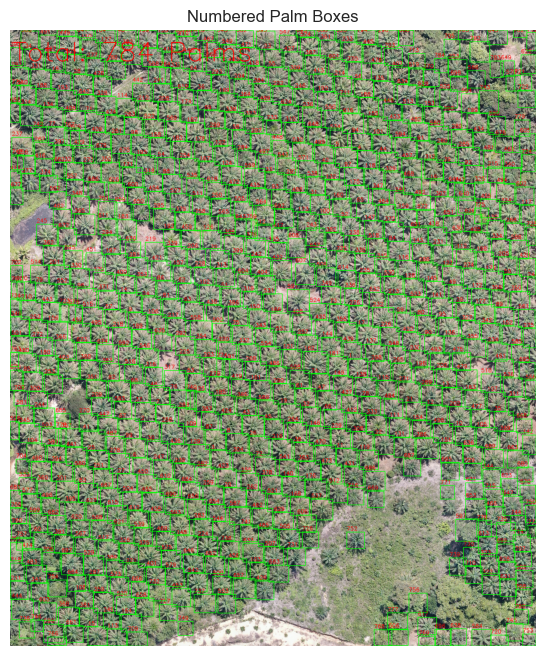

In [120]:
model = YOLO("runs/detect/train/weights/best.pt")  # load trained model
img_path = '../data/count/raw/count1.jpeg'
image= cv2.imread(img_path)

# inference
results = model(image, conf=0.4, iou=0.3, max_det=99999)
result = results[0]  

# box and class ID
boxes = result.boxes.xyxy.cpu().numpy()
class_ids = result.boxes.cls.cpu().numpy()

# Filter for only palm tree (class_id == 0)
palm_indices = np.where(class_ids == 0)[0]
filtered_boxes = boxes[palm_indices]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw boxes only for palm trees
for i, box in enumerate(filtered_boxes, start=1):
    x1, y1, x2, y2 = map(int, box[:4])
    label = f"{i}"
    cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=5)
    cv2.putText(image, label, (x1, max(y1 - 20, 20)),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=2, color=(255, 0, 0), thickness=3)

# Add total count of palms
total = len(filtered_boxes)
cv2.putText(image, f"Total: {total} Palms", (30, 350), cv2.FONT_HERSHEY_SIMPLEX, 10, (255, 0, 0), 10)

# Save the image with bounding boxes
cv2.imwrite("../data/count/processed/annotated_image.jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Display
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.title("Numbered Palm Boxes")
plt.show()

# Image tiling

Image tiling, in the context of computer vision and image processing, refers to the technique of dividing a large image into smaller, overlapping or non-overlapping rectangular sections called tiles. This method is particularly useful for handling high-resolution images, especially when processing them for object detection or segmentation tasks. 

and i found this cool library that can do image tiling easily, because it abstracts complex operations like image slicing, overlapping box handling, and annotation into simple, modular components. without manually handling coordinates or merging results. This streamlined design saves time, making it ideal for working with large images and custom detection tasks.

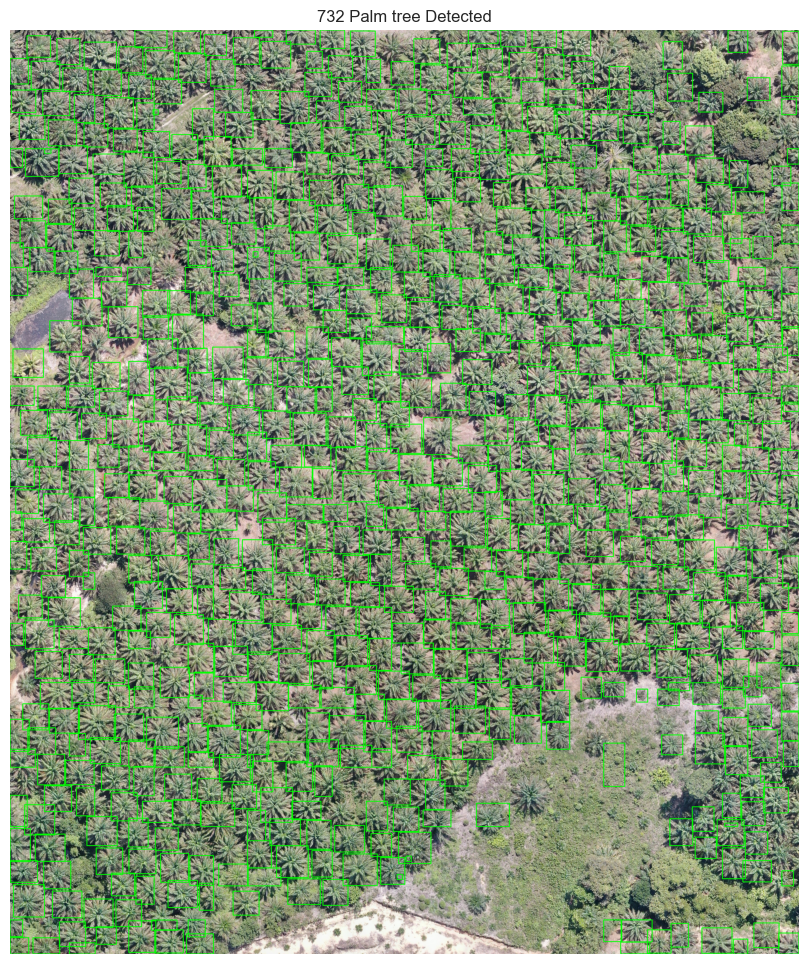

In [108]:
model = YOLO("runs/detect/train/weights/best.pt")

image = cv2.imread("../data/count/raw/count1.jpeg")

def callback(image_slice: np.ndarray) -> sv.Detections:
    result = model(image_slice, verbose=False, conf=0.4, agnostic_nms=True)[0]
    return sv.Detections.from_ultralytics(result)

from supervision import InferenceSlicer, OverlapFilter

slicer = InferenceSlicer(
    slice_wh=(640, 640),
    overlap_ratio_wh=None,
    overlap_wh = (int(640 * 0.3), int(640 * 0.3)),  # = (192, 192)
    callback=callback,
    overlap_filter=OverlapFilter.NON_MAX_SUPPRESSION,
    iou_threshold=0.1
)

# Run slicing inference
detections = slicer(image)
# 🔍 Filter to only class ID 0 (palm trees)
detections = detections[detections.class_id == 0]
from supervision import BoxAnnotator
# Draw bounding boxes using BoxAnnotator
box_annotator = BoxAnnotator(color=sv.Color.GREEN, thickness=5)
annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections)

# Save or display the result
cv2.imwrite("../data/count/final_combined.jpg", annotated_image)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"{len(detections)} Palm tree Detected")
plt.show()

Well it doesn't look better than the first one (without image tiling), why is it? 


probably because the model learns to recognize objects with full spatial context, including surrounding background, nearby objects, and full object shapes. so when i apply tiling during inference, objects may be partially visible or cut off at tile edges, which creates input patterns the model never saw during training. 

In [85]:
model = YOLO("runs/detect/train/weights/best.pt")
metrics = model.val(data="../data/count/raw/new_dataset/data.yaml", split="test", iou=0.5, conf=0.25)

Ultralytics 8.3.162  Python-3.11.0 torch-2.1.0+cpu CPU (Intel Core(TM) i7-8750H 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.50.3 ms, read: 183.0191.9 MB/s, size: 374.8 KB)


val: Scanning C:\Users\zidny\Documents\CV\AIEngineerV2025-20250114\data\count\raw\new_dataset\test\labels.cache... 95 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:20<


                   all         95       6973      0.946      0.937      0.968      0.644
             Palm tree         95       6148      0.939      0.935      0.963      0.619
                  Tree          8        825      0.953      0.938      0.972      0.669
Speed: 1.2ms preprocess, 96.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\val


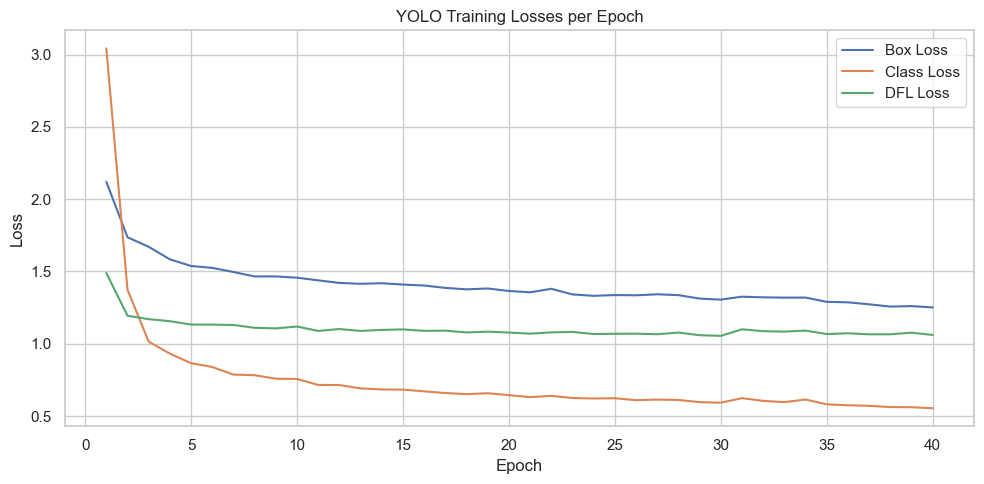

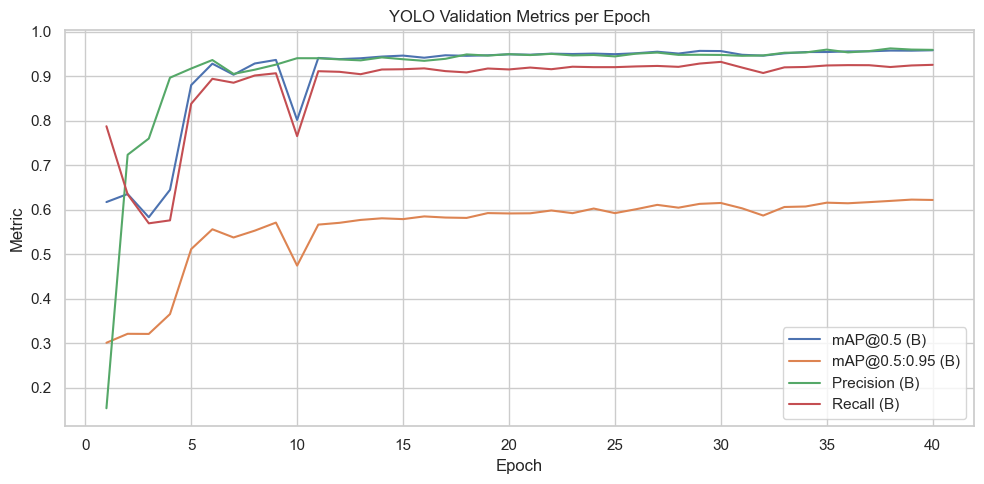

In [86]:
# Load results
df = pd.read_csv('runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# Plot Training Losses
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
plt.plot(df['epoch'], df['train/dfl_loss'], label='DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('YOLO Training Losses per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Validation mAP and Recall/Precision
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5 (B)')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95 (B)')
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision (B)')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall (B)')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('YOLO Validation Metrics per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


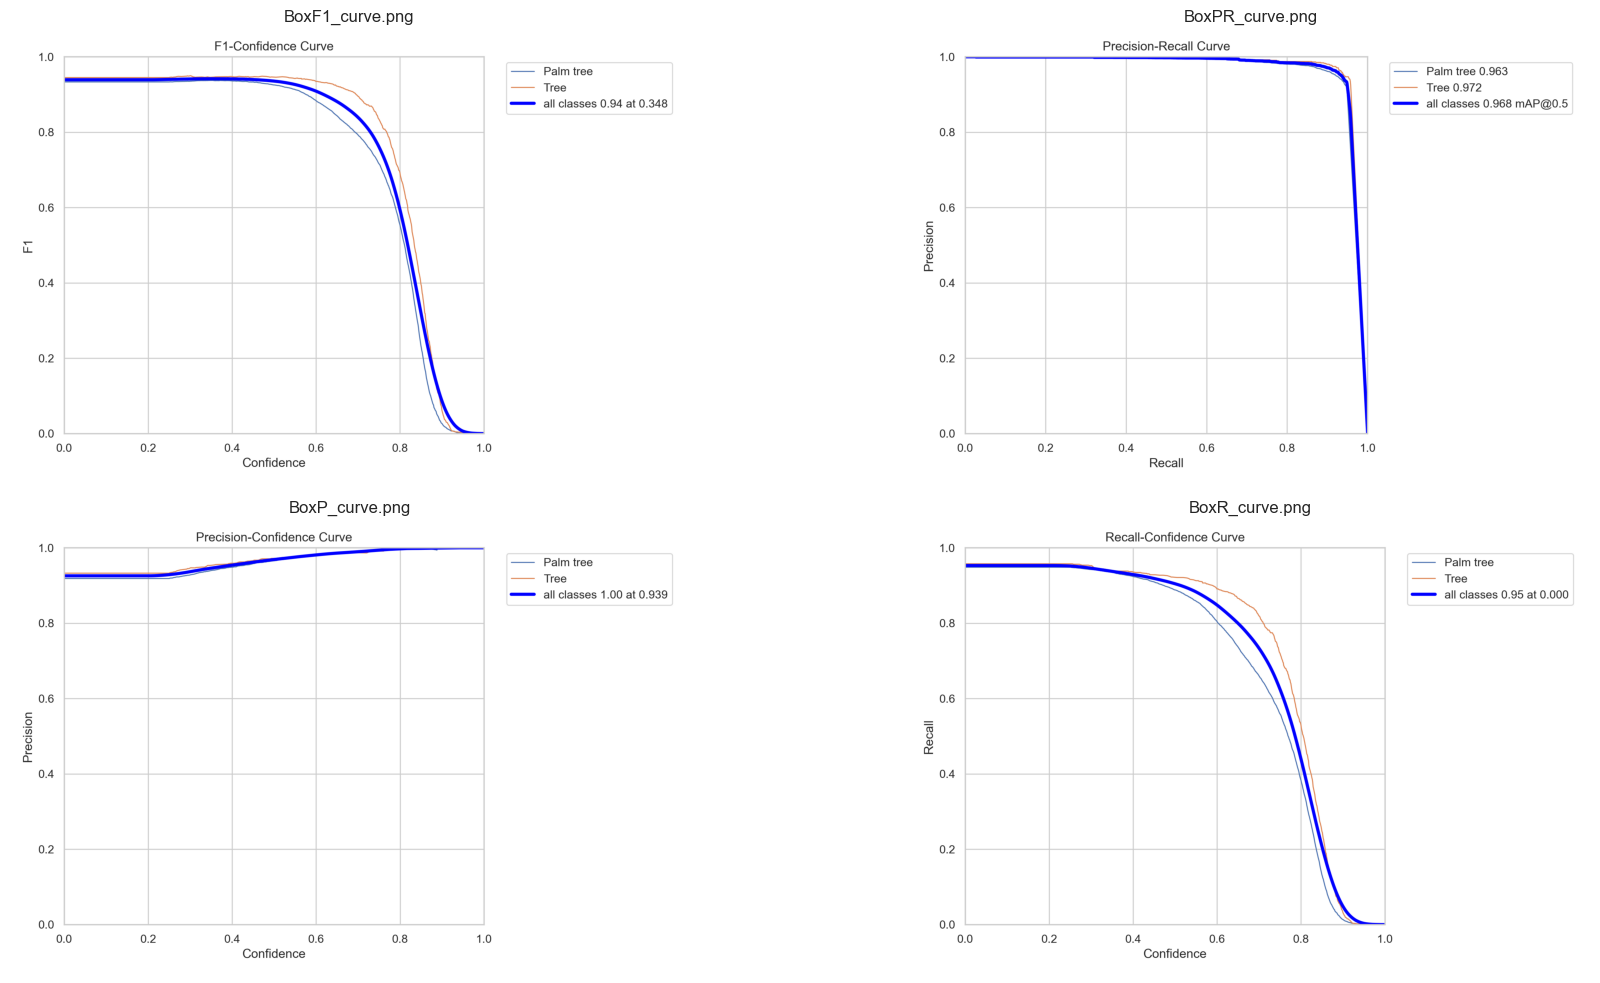

In [87]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to latest val output directory
val_output_dir = "runs/detect/val"  # replace 'exp' if it's named 'exp2' etc.

# Get all result images
result_images = [f for f in os.listdir(val_output_dir) if f.endswith(("curve.png"))]

# Show a few result images
plt.figure(figsize=(20, 10))
for i, img_name in enumerate(result_images[:5], 1):
    img_path = os.path.join(val_output_dir, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 2, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name)

plt.tight_layout()
plt.show()


**Precision-Recall Curve** 
Both palm tree and tree curves are very tight and close to the top-right corner, this indicates high precision and recall, which means few false positives and few missed detections. Very small performance drop as recall approaches 1.0, suggesting strong generalization.

**F1-Confidence Curve**
F1 score remains stable and high (close to 1.0) up to ~0.7 confidence, after which it drops steeply. Best trade-off confidence is around 0.34, this is where precision and recall are best balanced. Tells us that the model is most effective when keeping predictions with confidence ≥0.34.

**Precision-Confidence Curve**
Precision stays flat near 1.0 across all confidence levels. This means when the model makes a prediction, it’s usually correct.

**Recall-Confidence Curve**
Recall is high (>0.95) at lower confidence thresholds and slowly drops as confidence increases. Suggests that filtering out low-confidence predictions might reduce recall sharply, especially beyond 0.8.

Recall drops earlier for Palm trees compared to Trees, it means that palm trees are more likely to be missed when increasing confidence thresholds. 


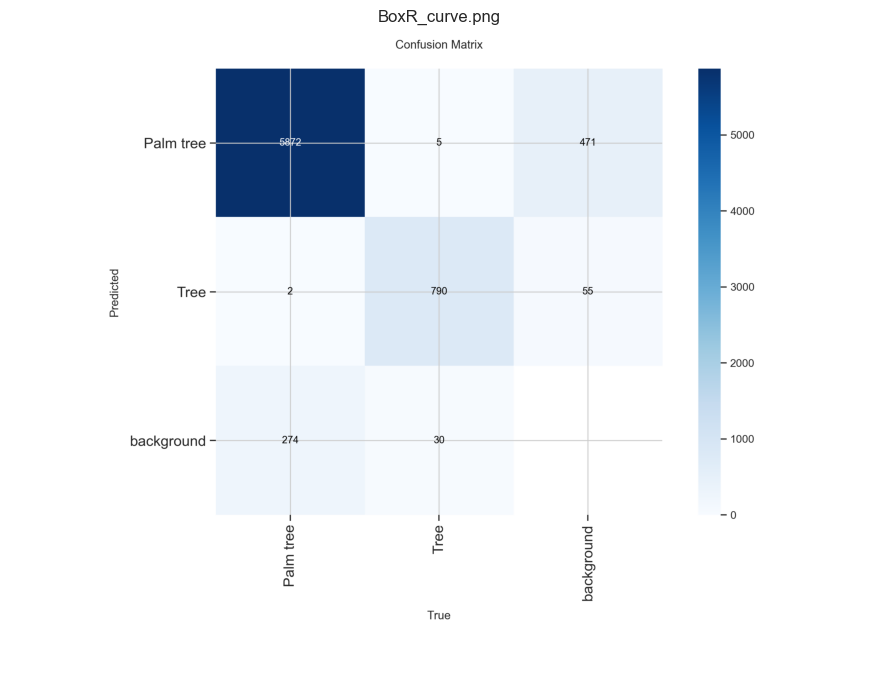

In [88]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to latest val output directory
conv_matrix = "runs/detect/val/confusion_matrix.png"  # replace 'exp' if it's named 'exp2' etc.

# Show a few result images
plt.figure(figsize=(20, 7))

img = mpimg.imread(conv_matrix)

plt.imshow(img)
plt.axis('off')
plt.title(img_name)

plt.tight_layout()
plt.show()


The model does a pretty good job at telling apart palm trees and trees, but it still has some problems. First, it often thinks palm trees are background. This happens because the background in many training images is full of green areas that look like palm trees, so the model probably gets confused.

Second, some tree objects are also misclassified as background or even palm trees. Even though I included the tree class during training, so the model actually knows the difference between trees and palm trees, it still makes mistakes. This might be because trees and palm trees share similar shapes or textures, especially from far away or in blurry images.

To improve this, we need a clearer dataset or higher-resolution images where each class stands out more. Adding more variety can also help the model learn better differences between objects and background.

# Future Reference

With my potato PC and limited time, this is probably the best result I can deliver for now. But, if I continue this project in the future, here are some points to consider,

**Higher Resolution During Training**
Increase the input size (e.g., 1280×1280 instead of 640×640) so the model can detect smaller or partially visible objects more accurately without relying on tiling.

**Add More Hard Negatives**
Expand the "Not Palm" and background class with more visually similar trees to reduce false positives and improve the model’s ability to distinguish between palm trees and other tree types / background.

**Fine-Tune with Real Deployment Data**
Collect images from actual deployment environment like drone footage, satellite images, and annotate them, and fine-tune the model to adapt it better to the real world.